# Машинное обучение, DS-поток, осень 2024
## Задание ML.8


Задача 1: Реализация модулей.
▫️ Sequential реализован. (20.0)
▫️ Linear реализован. (30.0)
▫️ Softmax реализован. (35.0)
▫️ ReLU реализован. (15.0)
▫️ LeakyReLU реализован. (15.0)
▫️ NLLCriterion реализован. (20.0)
▫️ SGD реализован. (15.0)
▫️ Молодец! (0.0)
Баллы: 150.0 / 150.0

**Баллы за задание:**

* Реализация модулей **`1_modules.ipynb`** — **150 баллов**.
* Применение модулей на синтетических данных **`2_train.ipynb`** — **60 баллов**.
* Исследование проcтых нейронных сетей **`3_research.ipynb`** — **60 баллов**.

<h1 align=center>
    Добро пожаловать в Глубокое обучение!
</h1>

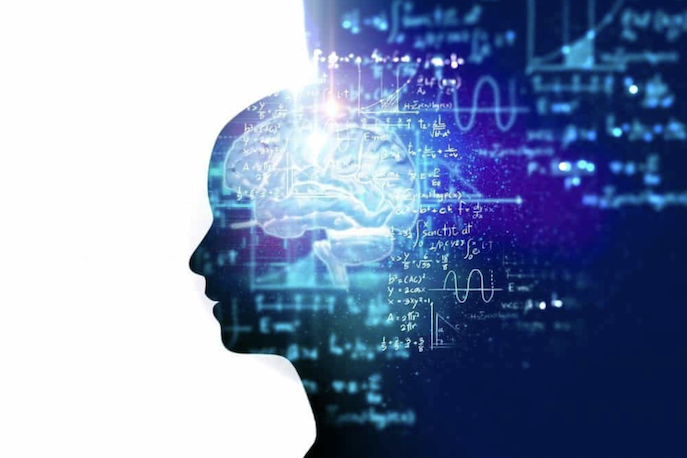

В этом домашнем задании вам предстоит самостоятельно реализовать самые важные компоненты нейросети, **используя только `NumPy`**.

Ноутбуков в задании много (целых 3), однако большая часть кода написана за вас 😉 Вам предстоит лишь  разобраться в уже написанном коде, понять, как работают некоторые важные компоненты нейронных сетей и написать недостающие строки кода, чтобы все заработало.

Структура задания подразумевает выполнение 3-х `jupyter notebook`'ов.

**`1_modules.ipynb`**: текущий ноутбук. Нужно реализовать слои нейронной сети, используя только библиотеку NumPy. В конце ноутбука запускается скрипт **`test.py`** для проверки работы всех компонент.

**`2_train.ipynb`**: ноутбук, который нужно запустить, когда все слои уже реализованы.  

**`3_research.ipynb`**: ноутбук, независимый от предыдущих трех, где нужно будет произвести исследование простой нейронной сети.

# 1. Введение

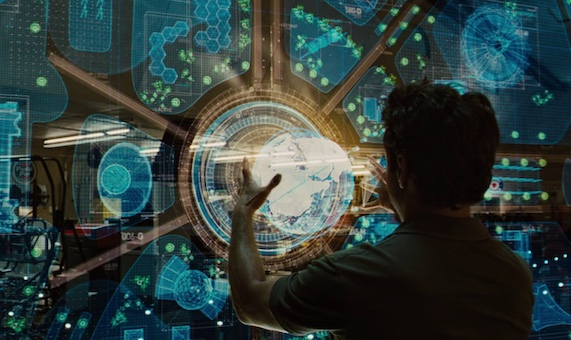

Мы хотим построить "с нуля" свой мини-фреймворк для обучения нейронных сетей. Он должен позволять создавать, обучать и тестировать нейросети. Как известно из лекции и семинара, **цикл обучения нейросети** выглядит так:


```
# однослойная нейросеть
model = Sequential()
model.add(Linear(2,2))
model.add(LogSoftMax())

criterion = NLLCriterion()

optimizer = SGD(lr=1e-2, momentum=0.9)

# одна эпоха -- один проход по обучающей выборке
for i in range(n_epoch):
    # одна итерация -- один батч
    for x_batch, y_batch in train_generator(sample, labels, batch_size):
        # Обнуляем градиенты с предыдущей итерации
        model.zero_grad_params()
        # Forward pass
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward pass
        last_grad_input = criterion.backward(predictions, y_batch)
        model.backward(x_batch, last_grad_input)
        # Обновление весов
        optimizer(
            model.get_params(),
            model.get_grad_params(),
            opt_params,
            opt_state
        )
 ```

## Проектирование фреймворка

### 1. Базовые концепции

**Нейросеть** $-$ это последовательность слоев. В реализации ее удобно представлять абстракцией `Sequential`.

**Слой** $-$ это некоторая функция, у которой в общем случае есть обучаемые параметры. Есть слои и без обучаемых параметров (например, функции активации, SoftMax, LogSoftMax), однако все эти функции все равно удобно называть слоями нейросети. В реализации один слой удобно представлять абстракцией `Module`.

Каждый слой должен уметь делать прямой проход **forward pass**, и обратный проход **backward pass**. В реализации forward pass удобно представлять абстрактным методом `forward()`, backward pass &mdash; абстрактным методом `backward()`.

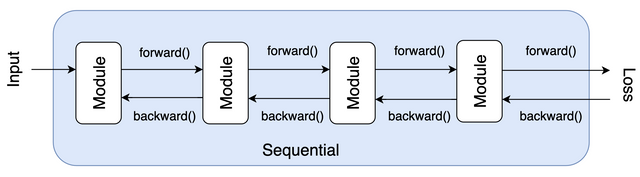

### 2. Forward pass

Forward pass является *первым этапом итерации обучения нейросети*. После выполнения этого этапа сеть должна выдать вычисленное преобразование входа.

*   Во время вызова метода `forward()` у `Sequential`, вход, поданный нейросети, проходит через все ее слои "вперед", до выходного слоя.
*   Во время вызова метода `forward()` у `Module`, над входом, поданным слою, осуществляется операция этого слоя (линейная, SoftMax).





В реализации ниже у каждого слоя во время `forward()` будет вызываться только один метод $-$ `update_output()`, который производит вычисление операции слоя. Важно отметить, что при вызове `update_output()` его выход **сохраняется в поле `self.output`** вызвавшего слоя. Это необходимо, поскольку выходы слоёв потом используются в **backward pass**.

### 3. Backward pass
> Смотри напоминание теории в BackwardPass.pdf на вики.

*   Во время вызова метода `backward()` у `Sequential` мы в цикле вычисляем `backward()` для всех слоев нейросети в соответствии с *chain rule*.
*   Во время вызова метода `backward()` у `Module` вызываются два метода $-$ `update_grad_params()` и `update_grad_input()`.
*   `update_grad_params()` вычисляет $\frac{\partial L}{\partial \theta_k}$ &mdash; градиент функции потерь по параметрам слоя $k$.
*   `update_grad_input()` вычисляет $\frac{\partial L}{\partial x_{k}}$ &mdash; градиент функции потерь по входу  слоя $k$. Этот градиент затем передается предыдущему слою $k - 1$ в виде `grad_output`.


***Важно:*** в chain rule присутствуют произведения градиентов. Они могут быть векторами/матрицами, поэтому при умножении следует использовать именно **матричное произведение**, если выводите формулы через производную по вектору/матрице. Если же выводите "поэлементно" (как в примере с `LogSoftMax`), то форма произведений будет видна из вывода.

### 1.4. Обновление весов

Обновление весов (оптимизация) является *третьим, последним этапом итерации обучения нейросети*. После выполнения этого этапа все обучаемые параметры всех слоев нейросети должны изменить свое значение (обновиться) в соответствии с правилами оптимизатора.

# 2. Реализация (150 баллов)

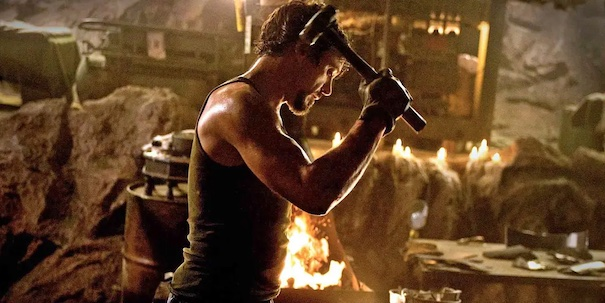

Вам предстоит реализовать компоненты нейронной сети, используя **только библиотеку NumPy**:

> **Базовые концепции**:
- [x] `Module`     $-$ абстрактный класс для компонент нейронной сети;
- [ ] *(20 баллов)* `Sequential` $-$ класс, содержащий в себе последовательность объектов класса `Module`.

> **Слои**:
- [ ] *(30 баллов)* `Linear`     $-$ линейный слой;
- [ ] *(35 баллов)* `SoftMax`    $-$ слой, вычисляющий операцию *softmax*;
- [x] `LogSoftMax` $-$ слой, вычисляющий операцию *log(softmax)*;

> **Функции активации** (тоже являются слоями, но выделены в отдельную секцию для удобства):
- [ ] *(15 баллов)* `ReLU`      $-$ функция активации *Rectified Linear Unit*;
- [ ] *(15 баллов)* `LeakyReLU` &mdash;  функция активации Leaky Rectified Linear Unit;

> **Функции потерь**:
- [x] `Criterion`  $-$ абстрактный класс для функций потерь;
- [ ] *(20 баллов)* `NLLCriterion` $-$ negative log-likelihood функция потерь.

> **Оптимизаторы**:
- [ ] *(15 баллов)* `SGD`  $-$ алгоритм стохастического градиентного спуска.

**Галочками** помечены те слои, которые **уже реализованы за вас**. Таким образом, задание состоит в реализации оставшихся слоёв (мы заботимся о вашем здоровье 🍀).

В уже реализованных за вас модулях (отмечены галочкой) формулы для вычисления backward pass тоже уже даны, в остальных их нужно вывести самим по аналогии.

**В скобках перед названием слоя указаны баллы за его реализацию и за вывод формулы для backward pass. Они засчитываются только тогда, когда слой проходит все тесты в`test.py`, см. в конце ноутбука.**

In [4]:
import numpy as np

##  2.1. Базовые концепции

### 2.1.1. Module &mdash; полностью реализован за вас

**Module** $-$ абстрактный класс, который определяет методы, которые могут быть реализованы у каждого слоя.

*   forward pass: просто вычисляет операцию слоя:
    `output = module.forward(input)`

*   backward pass: дифференцирует функцию слоя по входу и по параметрам, возвращает градиент по входу этого слоя:
    `grad_input = module.backward(input, grad_output)`

Пожалуйста, **внимательно прочитайте методы и их описания**, чтобы ориентироваться в дальнейшем.

In [6]:
class Module(object):
    """ Абстрактный класс для слоев нейросети. """
    def __init__ (self):
        self.output = None
        self.grad_input = None

    def forward(self, input):
        """
        Вычисляет операцию слоя.
            `input (np.array)` -- вход слоя
        returns:
            `self.update_output(input) (np.array)` -- вычисленная операция слоя
        """
        return self.update_output(input)

    def backward(self, input, grad_output):
        """
        Осуществляет шаг backpropagation для этого слоя,
        дифференцируя функцию слоя по входу и по параметрам.
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        returns:
            `self.grad_input (np.array)` -- градиент функции слоя по входу
        """

        self.update_grad_input(input, grad_output)
        self.update_grad_params(input, grad_output)
        return self.grad_input

    def update_output(self, input):
        """
        Реализация `forward()` для данного слоя.
        Вычисляет функцию слоя (линейную, `ReLU`, `SoftMax`) по входу `input`.
            `input (np.array)` -- вход слоя
        returns:
            `self.output (np.array)` -- вычисленная операция слоя, сохраненная в поле класса
        """
        pass

    def update_grad_input(self, input, grad_output):
        """
        Вычисляет градиент функции потерь по входу `input` и возвращает его в виде `self.grad_input`.
        Размер (`shape`) поля `self.grad_input` всегда совпадает с размером `input`.
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        returns:
            `self.grad_input (np.array)` -- вычисленный градиент функции  потерь по входу `input`
        """
        pass

    def update_grad_params(self, input, grad_output):
        """
        Вычисляет градиент функции потерь по параметрам (весам) этого слоя.
        Ничего не возвращает, только сохраняет значения градиентов в соответствующие поля.
        Не нужно реализовывать этот метод, если у слоя нет параметров (у функций активации,
        `SoftMax`, `LogSoftMax`).
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        pass

    def zero_grad_params(self):
        """
        Обнуляет градиенты у параметров слоя (если они есть).
        Нужно для оптимизатора.
        """
        pass

    def get_parameters(self):
        """
        Возвращает список параметров этого слоя, если они есть. Иначе вернуть пустой список.
        Нужно для оптимизатора.
        """
        return []

    def get_grad_params(self):
        """
        Возвращает список градиентов функции этого слоя по параметрам этого слоя, если они есть.
        Иначе вернуть пустой список. Нужно для оптимизатора.
        """
        return []


    def __repr__(self):
        """
        Напечатать название слоя КРАСИВО.
        """
        return 'Module'

### 2.1.2. Sequential

Многослойная нейронная сеть состоит из последовательности модулей. Реализуйте класс **Sequential**, руководствуясь механикой forward и backward pass'ов, а также описаниями каждого метода. Убедитесь, что на вход каждому слою в методе `backward()` вы подаете  НЕ `input` к этому `backward`'у нейросети, а именно тот вход, который слой `i` получал на соответствующей итерации `forward`'а (выход слоя `self.modules[i]`).

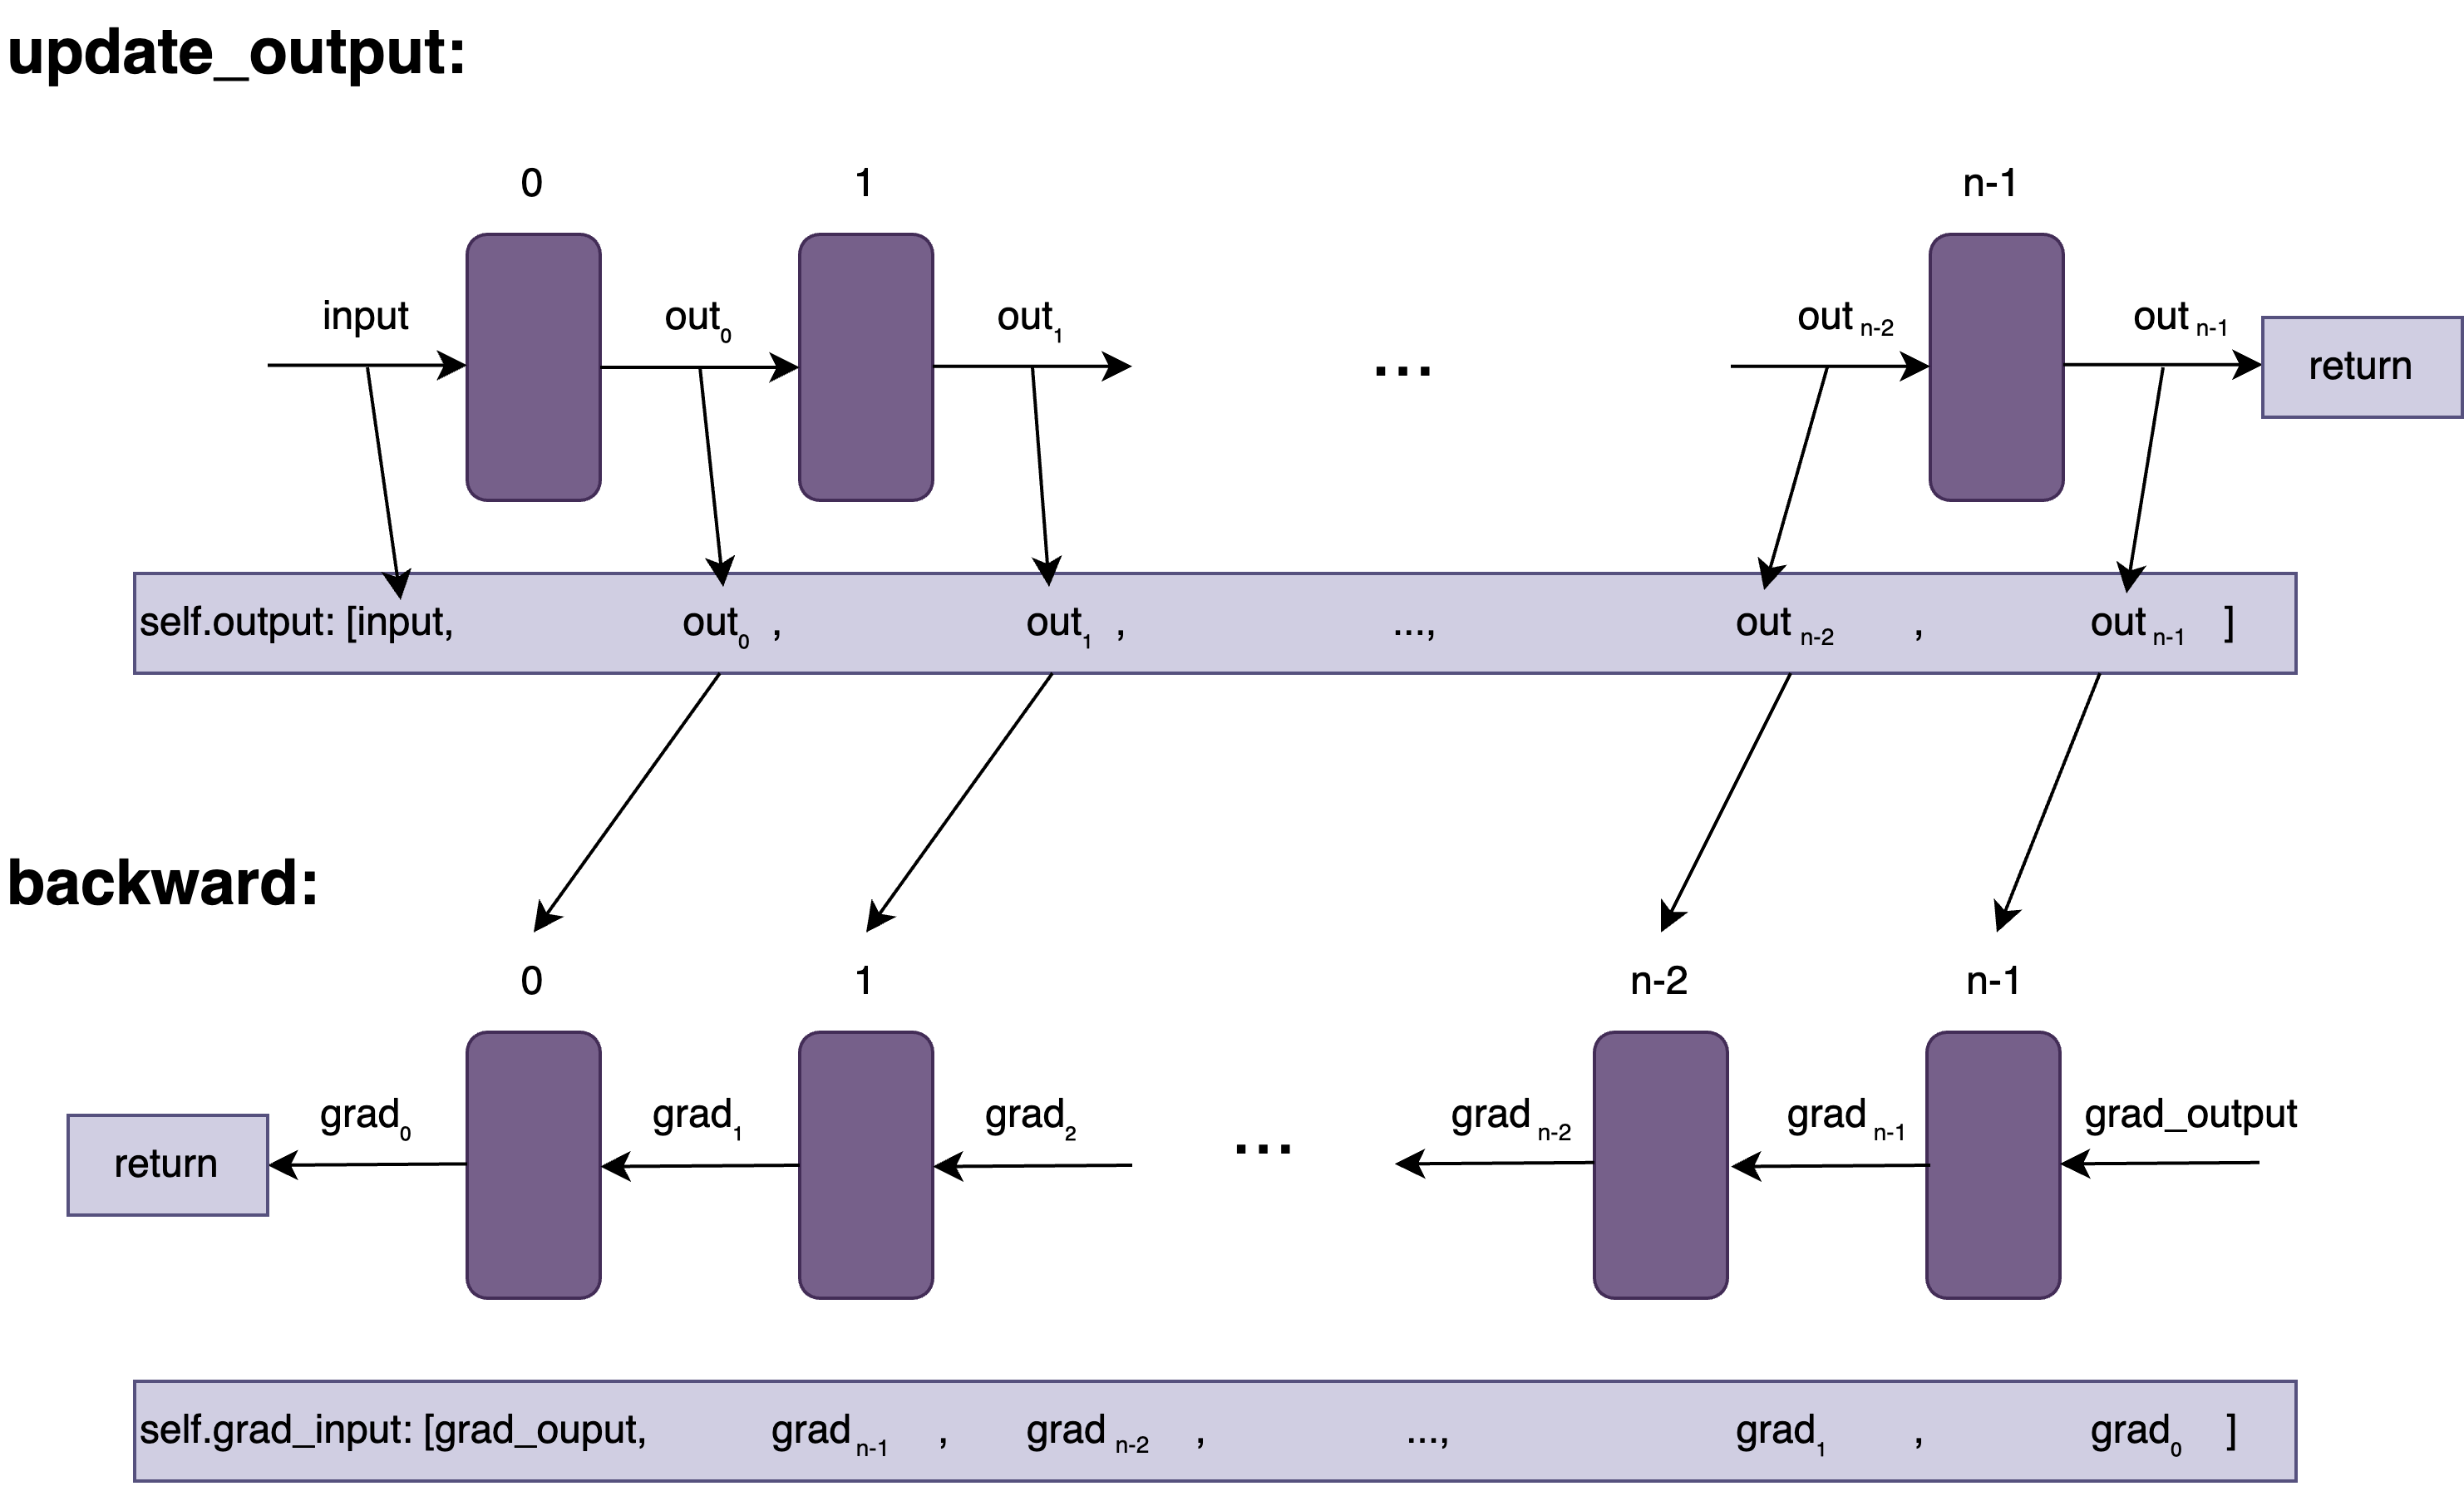

In [7]:
class Sequential(Module):
    """
        Последовательность модулей (слоев).
        Последовательно обрабатывает вход `input` от слоя к слою.
    """
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Добавляет модуль в контейнер.
        """
        self.modules.append(module)

    def update_output(self, input):
        """
        Сохраняет выходы каждого модуля в self.output.
        Возвращает выход последнего модуля.
        """
        self.output = [input]

        for modul in self.modules:
            self.output.append(modul.forward(self.output[-1]))

        return self.output[-1]

    def backward(self, input, grad_output):
        """
        Сохраняет градиенты функции потерь по входу для каждого модуля в self.grad_input.
        Возвращает первый такой градиент.
        """
        self.grad_input = [grad_output]

        modules_reversed = self.modules[::-1]

        for i, module in enumerate(modules_reversed):
            if i < len(self.modules) - 1:
                inp = modules_reversed[i + 1].output
            else:
                inp = input
                
            self.grad_input.append(module.backward(inp, self.grad_input[-1]))

        return self.grad_input[-1]


    def zero_grad_params(self):
        for module in self.modules:
            module.zero_grad_params()

    def get_parameters(self):
        return [x.get_parameters() for x in self.modules]

    def get_grad_params(self):
        return [x.get_grad_params() for x in self.modules]

    def __repr__(self):
        return "".join([str(x) + '\n' for x in self.modules])

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

## 2.2. Слои

### 2.2.1. Linear

Линейный слой, также известный как `Fully-Connected (FC)` или `Dense`, осуществляет линейное (аффинное) преобразование.

Везде ниже $N$ - размер батча, $d$ - число признаков во входном тензоре, $K$ - количество нейронов в слое.

*Forward pass:*

$$
x \in \mathbb{R}^{N \times d}, W \in \mathbb{R}^{d \times K}, b \in \mathbb{R}^{1 \times K}
$$

$$
\text{Linear}(x) = x W + b = y
$$

$$
\text{Linear}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:* *(посмотрите в [ДЗ-10 с "Введения в анализ данных"](https://miptstats.github.io/courses/ad_fivt/task10.html), задача 1, пункт 2.2)*

Пусть $L$ — это функция потерь

В обратном проходе (backward pass) для линейного слоя вычисляются градиенты по параметрам $W$, $b$ и входным данным $x$ на основе градиента ошибки по выходу слоя $\frac{\partial L}{\partial y}$.


Один индекс -- столбец, два индекса -- строка и столбец
$$
\frac{\partial L}{\partial W_k} = \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial W_k} = x^T \frac{\partial L}{\partial y_k}\\
\frac{\partial L}{\partial b_k} = \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial b_k} = \sum\limits_{j=0}^N\frac{\partial L}{\partial y_{jk}} \\
\frac{\partial L}{\partial x_k} = \sum\limits_{j=1}^K\frac{\partial L}{\partial y_j} \frac{\partial y_j}{\partial x_k} = \frac{\partial L}{\partial y_k} W_k^T \\
$$

In [8]:
class Linear(Module):
    """
    Слой, осуществляющий линейное преобразование
    """
    def __init__(self, n_in, n_out):
        '''
        Поля:
            W - матрица весов слоя размера (n_in, n_out);
                n_in - число признаков,
                n_out - количество нейронов в слое
            b - вектор свободных членов, по одному числу на один нейрон
            gradW - хранит градиент матрицы весов линейного слоя
            gradb - хранит градиент вектора свободных членов
        '''
        super(Linear, self).__init__()

        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """
        self.output = input @ self.W + self.b

        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        self.grad_input = grad_output @ self.W.T

        return self.grad_input

    def update_grad_params(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        self.gradW = input.T @ grad_output
        self.gradb = grad_output.sum(axis=0)

        assert self.gradb.shape == self.b.shape

    def zero_grad_params(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def get_parameters(self):
        return [self.W, self.b]

    def get_grad_params(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = f'Linear {s[0]} -> {s[1]}'
        return q

### 2.2.2. SoftMax

SoftMax слой осуществляет softmax-преобразование:

$$
\text{SoftMax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

#### Forward pass:

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча SoftMax записывается так:

$$
\text{SoftMax}(x) = \begin{pmatrix}
\frac{e^{x_{11}}}{\sum_{j=1}^K e^{x_{1j}}} & \frac{e^{x_{12}}}{\sum_{j=1}^K e^{x_{1j}}} & \dots & \frac{e^{x_{1K}}}{\sum_{j=1}^K e^{x_{1j}}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{e^{x_{N1}}}{\sum_{j=1}^K e^{x_{Nj}}} & \frac{e^{x_{N2}}}{\sum_{j=1}^K e^{x_{Nj}}} & \dots & \frac{e^{x_{NK}}}{\sum_{j=1}^K e^{x_{Nj}}}
\end{pmatrix}
$$

где $\text{SoftMax}(x) \in \mathbb{R}^{N \times K}$.

#### Backward pass:

SoftMax не имеет параметров, но применяется ко входу поэлементно, поэтому при дифференцировании выходного значения слоя по входу получается не градиент, а якобиан — матрица производных. Пусть $x$ — это один вектор-строка из батча, имеющая длину $K$.

#### Якобиан SoftMax по входу:

Рассмотрим выход SoftMax:

$$
\text{SoftMax}(x) = \begin{pmatrix}
\frac{e^{x_{1}}}{\sum_{j=1}^K e^{x_{j}}} & \frac{e^{x_{2}}}{\sum_{j=1}^K e^{x_{j}}} & \dots & \frac{e^{x_{K}}}{\sum_{j=1}^K e^{x_{j}}}
\end{pmatrix} = \begin{pmatrix}
a_1 & a_2 & \dots & a_K
\end{pmatrix}
$$

Обозначим выход SoftMax за $a$ для удобства. Тогда якобиан SoftMax будет иметь следующий вид:

$$
\frac{\partial \text{SoftMax}}{\partial x} = \begin{pmatrix}
\frac{\partial a_1}{\partial x_1} & \frac{\partial a_1}{\partial x_2} & \dots & \frac{\partial a_1}{\partial x_K} \\
\frac{\partial a_2}{\partial x_1} & \frac{\partial a_2}{\partial x_2} & \dots & \frac{\partial a_2}{\partial x_K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{\partial a_K}{\partial x_1} & \frac{\partial a_K}{\partial x_2} & \dots & \frac{\partial a_K}{\partial x_K} \\
\end{pmatrix}
$$

Каждый элемент этой матрицы имеет следующий вид. Для частной производной $\frac{\partial a_k}{\partial x_s}$:

1. Если $k = s$ (диагональные элементы):
   $$
   \frac{\partial a_k}{\partial x_k} = a_k (1 - a_k)
   $$

2. Если $k \neq s$ (все остальные элементы):
   $$
   \frac{\partial a_k}{\partial x_s} = a_k \cdot a_s
   $$

Таким образом, для **одной строки в батче** якобиан SoftMax по входу принимает следующий вид:

$$
\frac{\partial \text{SoftMax}}{\partial x} = \begin{pmatrix}
a_1 (1 - a_1) & a_1 a_2 & \dots & a_1 a_K \\
a_2 a_1 & a_2 (1 - a_2) & \dots & a_2 a_K \\
\vdots  & \vdots  & \ddots & \vdots  \\
a_K a_1 & a_K a_2 & \dots & a_K (1 - a_K) \\
\end{pmatrix}
$$

#### Вывод `grad_input`:

Для вычисления градиента по входу $\frac{\partial L}{\partial x}$, если $\frac{\partial L}{\partial a}$ — градиент функции потерь по выходу SoftMax, применяем правило матричного умножения:

$$
\frac{\partial L}{\partial x_s} = \frac{\partial L}{\partial a_s} (1 - a_s) + \sum_{i \ne s} \frac{\partial L}{\partial a_i} a_s
$$

Или, эквивалентно, в векторной форме для всех компонент:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial a} - \left( \sum_{i=1}^K \frac{\partial L}{\partial a_i} \right) a
$$


Смотрите *Backward pass* для `LogSoftMax` ниже.

*Подсказка:* В коде используйте свойство: $\text{softmax}(x) = \text{softmax}(x - \text{const})$. Это позволяет избежать переполнения при вычислении экспоненты.

In [3]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """

        self.output = input - input.max(axis=1, keepdims=True)
        self.output = np.exp(self.output) / np.exp(self.output).sum(axis=1, keepdims=True)

        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """

        self.grad_input = self.output * grad_output
        self.grad_input -= self.output * np.sum(self.grad_input, axis=1).reshape(-1, 1)

        return self.grad_input

    def __repr__(self):
        return 'SoftMax'

### 2.2.3. LogSoftMax &mdash; полностью реализован за вас

LogSoftMax слой есть просто логарифм от softmax-преобразования:

$$
\text{LogSoftMax}(x)_i = \log(\text{SoftMax}(x))_i = x_i - \log {\sum_j \exp x_j}
$$

*Forward pass:*

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча LogSoftMax записывается так:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_{11} - \log {\sum_{j=1}^K e^{x_j}} & x_{12} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{1K} - \log {\sum_{j=1}^K e^{x_j}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{N1} - \log {\sum_{j=1}^K e^{x_j}} & x_{N2} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{NK} - \log {\sum_{j=1}^K e^{x_j}} \\
\end{pmatrix}
$$

$$
\text{LogSoftMax}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

LogSoftMax не имеет параметров, но применяется ко входу поэлементно, поэтому дифференцируя выход этого слоя по входу мы получаем не градиент (=вектор производных), а якобиан (=матрицу производных). Пусть $x$ сейчас $-$ это **один вектор-строка из батча**, имеющая длину $K$.

#### Якобиан LogSoftMax по входу:

Помним, что:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_1 - \log {\sum_{j=1}^K e^{x_j}} & x_2 - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_K - \log {\sum_{j=1}^K e^{x_j}}
\end{pmatrix} = \begin{pmatrix}
b_1 & b_2 & \dots & b_K
\end{pmatrix}
$$

$-$ обозначали за $b$ для удобства. Тогда:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
\frac{\partial b_1}{\partial x_1} & \frac{\partial b_1}{\partial x_2} & \dots & \frac{\partial b_1}{\partial x_K} \\
\frac{\partial b_2}{\partial x_1} & \frac{\partial b_2}{\partial x_2} & \dots & \frac{\partial b_2}{\partial x_K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{\partial b_K}{\partial x_1} & \frac{\partial b_K}{\partial x_2} & \dots & \frac{\partial b_K}{\partial x_K} \\
\end{pmatrix}
$$

Распишем один элемент этой матрицы и поймем, какой конкретно вид он имеет. Возьмем частную производную $b_k$ по $x_s$:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} \tag{1}
$$

Далее все зависит от $k$ и $s$. Если $k = s$, то первое слагаемое в (1) не зануляется и мы получаем:

$$
\frac{\partial b_k}{\partial x_k} = \frac{\partial x_k}{\partial x_k} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = 1 - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_k} = 1 - a_k
$$

**Где $a_k$ $-$ это $k$-ая компонента SoftMax-слоя от этого входа**. Если же $k \ne s$, то первое слагаемое в (1) обнулится:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} = a_s
$$

Таким образом для **одной строки в батче** получаем:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
(1 - a_1) & -a_2 & \dots & -a_K \\
-a_1 & (1 - a_2) & \dots & -a_K \\
\vdots  & \vdots  & \ddots & \vdots  \\
-a_1 & -a_2 & \dots & (1 - a_K) \\
\end{pmatrix}
$$

#### Вывод `grad_input`:

$$
\frac{\partial L}{\partial x_s} = \sum_{i=1}^K \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} \frac{\partial b_s}{\partial x_s} + \sum_{i\ne s} \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} (1 - a_s) + \sum_{i\ne s} \frac{\partial L}{\partial b_i} (-a_s) =
\frac{\partial L}{\partial b_s} - a_s \frac{\partial L}{\partial b_s} - a_s \sum_{i\ne s} \frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial b_s} - a_s \sum_{i=1}^K \frac{\partial L}{\partial b_i}
$$

Теперь легко записать формулу для `grad_input` в матричной форме, что и есть выход метода `update_grad_input()`.

*Подсказка:* В коде используйте свойство: $\text{LogSoftMax}(x) = \text{LogSoftMax}(x - \text{const})$. Это позволяет избежать переполнения при вычислении экспоненты.

In [9]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """
        # нормализуем для численной устойчивости
        self.output = input - input.max(axis=1, keepdims=True)
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1)).reshape(-1, 1)
        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        input_clamp = input - input.max(axis=1, keepdims=True)
        output = np.exp(input_clamp)
        output = output / np.sum(output, axis=1).reshape(-1, 1)

        self.grad_input = grad_output
        self.grad_input -= output * np.sum(grad_output, axis=1).reshape(-1, 1)

        return self.grad_input

    def __repr__(self):
        return 'LogSoftMax'

## 2.3. Функции активации

Функции активации $-$ это нелинейные функции, которые ставятся после `Linear`, `Conv` и других слоев. Именно благодаря им нейросети являются не просто одним большим линейным преобразованием, а сложной нелинейной функцией.

Достаточно исчерпывающий список с описанием преимуществ и недостатков каждой из функций активации [см. здесь](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/).

### 2.3.1. ReLU

**[Rectified Linear Unit](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)** (**ReLU**) $-$ одна из самых часто используемых функций активации.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{ReLU}(x) = \max(0, x) = \begin{cases}
  0, & x \le 0 \\    
  x & x \gt 0    
\end{cases}
$$

$$
\text{ReLU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

$\frac{\partial L}{\partial x_k} = \frac{\partial L}{\partial y_k}I\{x > 0 \}$

In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """

        self.output = np.maximum(0, input)

        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """

        self.grad_input = np.where(input > 0, 1, 0) * grad_output

        return self.grad_input

    def __repr__(self):
        return 'ReLU'

### 2.3.2. Leaky ReLU

**[Leaky Rectified Linear Unit](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)** (**LeakyReLU**) $-$ добавляет в ReLU контроль над зануляемой частью.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{LeakyReLU}(x) = \begin{cases}
  \gamma x, & x \le 0 \\    
  x & x \gt 0    
\end{cases}
$$

$$
\text{LeakyReLU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

$\frac{\partial L}{\partial x_k} = \frac{\partial L}{\partial y_k}I\{x > 0 \} + \frac{\partial L}{\partial y_k}\gamma I\{x \leq 0 \}$

In [11]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def update_output(self, input):

        self.output = np.where(input > 0, input, self.slope * input)

        return self.output

    def update_grad_input(self, input, grad_output):

        self.grad_input = np.where(input > 0, 1, self.slope) * grad_output

        return self.grad_input

    def __repr__(self):
        return 'LeakyReLU'

## 2.4. Функции потерь (loss, criterion, objective)

*Примечание:* Формально это не функции потерь, а функции риска. Везде далее и в во всех наших материалах, связанными с нейросетями, следующие слова являются синонимами: "лосс", "функция потерь", "loss", "criterion".

Функции потерь являются оптимизируемыми функциями в обучении с учителем. Если считать всю нейросеть одной большой функцией, то функцию потерь можно считать [функционалом](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB). Функции потерь не имеют параметров, а лишь вычисляют меру схожести ответов нейросети $\widehat{y}$ (prediction) с истинными ответами $y$ (target, ground truth).

### 2.4.1. Negative LogLikelihood criterion

**[NLLCriterion](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)** $-$ является отрицанием логарифма функции правдоподобия (likelihood function), используется в задаче классификации. Является частным случаем [дивергенции Кульбака-Лейблера](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0). Принимает на вход истинные вероятности классов $y$ и предсказанные вероятности классов $\widehat{y}$ от `LogSoftMax` слоя.

*Аналогичный критерий, принимающий на вход `SoftMax`-вероятности &mdash; менее стабилен: в нем возникают проблемы с вычислениями больших значений в `forward` и `backward`.*  

Истинные метки `y` на вход ожидаются уже **после One-Hot кодирования**.

*Forward pass:*

$$
\widehat{y} \in \mathbb{R}^{N \times K}
$$

$$
y \in \mathbb{R}^{N \times K}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \widehat{y}_{ij}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) \in \mathbb{R}
$$

*Backward pass:*

$\frac{\partial L}{\partial \widehat y} = -\frac{y}{N}$

In [12]:
class NLLCriterion(object):
    def __init__ (self):
        self.output = None
        self.grad_input = None

    def forward(self, input, target):
        """
        Вычисляет функцию потерь по входу `input` и истинными значениями `target`.
            `input (np.array)` -- вход слоя
            `target (np.array)` -- истинные ответы
        returns:
            `self.update_output(input, target) (np.array)` -- вычисленная функция потерь
        """
        return self.update_output(input, target)

    def backward(self, input, target):
        """
        Вычисляет градиент функции потерь по входу `input`.
        Использует для этого также истинные значения `target`.
            `input (np.array)` -- вход слоя
            `target (np.array)` -- истинные ответы
        returns:
            `self.update_grad_input(input, target) (np.array)` -- вычисленный градиент по входу `input`
        """
        return self.update_grad_input(input, target)

    def update_output(self, input, target):
        """
        Функция, реализующая `forward()`
            `input (np.array)` -- вход слоя
            `target (np.array)` -- истинные ответы
        """
        self.output = -1 / input.shape[0] * (input * target).sum()

        return self.output

    def update_grad_input(self, input, target):
        """
        Функция, реализующая `backward()`
            `input (np.array)` -- вход слоя
            `target (np.array)` -- истинные ответы
        """
        self.grad_input = -1 / input.shape[0] * target
        
        return self.grad_input

    def __repr__(self):
        return 'NLLCriterion'

## 2.5. Оптимизаторы

В данном случае это лишь один метод оптимизации $-$ стохастический градиентный спуск (SGD).

### 2.5.1. SGD

Оптимизатор, основанный на методе стохастического градиентного спуска.

In [16]:
def SGD(variables, gradients, config):
    '''
    Стохастический градиентный спуск.
    Обновляет значения переменных в соответствии с их градиентами и сохраняет градиенты в state.
        `variables` - список (`list`) списков переменных, которые нужно обновить
         (один список для одного слоя)
        `gradients` - список (`list`) списков градиентов этих переменных
         (ровно та же структура, как и у `variables`, один список для одного слоя)
        `config` - словарь (`dict`) c гиперпараметрами оптимизатора
         (сейчас это только `learning_rate`)
    returns:
        Ничего не возвращает. Обновляет значения градиентов
    '''

    learning_rate = config.get('learning_rate', 0.01) 
    
    for layer_vars, layer_grads in zip(variables, gradients):
        # Проходимся по переменным и соответствующим им градиентам внутри каждого слоя
        for var, grad in zip(layer_vars, layer_grads):
            var -= learning_rate * grad

---
## 2.6. Тестирование модулей
Запустим скрипт для тестирования `test.py` таким образом, чтобы он мог видеть все переменные среды ноутбука.

In [17]:
%run -i test.py

test_LeakyReLU (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_NLLCriterion (__main__.TestLayers) ... ok
test_ReLU (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... c:\Users\rusin\Desktop\физкек\ФПМИ\ДС-поток\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
ok
test_SoftMax (__main__.TestLayers) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.341s

OK


- Если хочется ускорить вычисления и написать действительно "свой PyTorch", можно использовать библиотеку [JAX](https://github.com/google/jax) от Google. Она является оберткой над [autograd](https://github.com/hips/autograd) (автоматическое дифференцирование) и [XLA](https://www.tensorflow.org/xla) (компиляция Python-кода)

- До сих пор мы производили все вычисления на CPU. Однако Deep Learning расцвел благодаря GPU. Более конкретно $-$ благодаря [Nvidia GPU](https://developer.nvidia.com/cuda-gpus) и [Nvidia CUDA](https://developer.nvidia.com/cuda-zone). Они также очень активно используются для [компьютерной графики](https://en.wikipedia.org/wiki/Computer_graphics)

- NumPy как раз можно запускать на GPU: раньше для этого чаще использовали [Numba](https://github.com/numba/numba), однако сейчас (в 2020 году) есть [много удобных библиотек для этого](https://stsievert.com/blog/2016/07/01/numpy-gpu/)

- Конечно же, вы всегда можете просто использовать PyTorch для работы с GPU, но не в этом ноутбуке :P

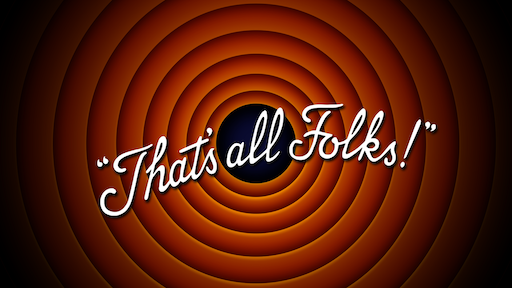